<a href="https://colab.research.google.com/github/aks2093/News_Categorization/blob/main/News_Categorization_3_approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os

data_path = "/content/drive/My Drive/news_categorization/data"

categories_data = pd.read_csv(os.path.join(data_path,"categories.csv"))
categories_mapping = pd.read_excel(os.path.join(os.path.join(data_path, "category_mapping.xlsx")))
news_details = pd.read_excel(os.path.join(data_path, "news_details.xlsx"))

In [ ]:
category = categories_data.to_dict()
category

{'category': {0: 'Layoff',
  1: 'Mergers and Acquisitions',
  2: 'Mass Hiring',
  3: 'Executive Movement',
  4: 'Centre Setup and Expansion',
  5: 'Deals',
  6: 'Partnerships'},
 'id': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}}

In [ ]:
#converting target "category_id" values [1,2,3,4,5,6,7] to [0,1,2,3,4,5,6]
categories_mapping["category_id"] = categories_mapping["category_id"].apply(lambda x:int(x)-1)
print(categories_mapping.__len__())
print(categories_mapping.columns)
print(categories_mapping["category_id"].unique())

3544
Index(['news_id', 'category_id'], dtype='object')
[3 1 4 6 5 0 2]


In [ ]:
categories_mapping["news_id"].unique().__len__()

2635

In [ ]:
categories_mapping.isna().sum()

news_id        0
category_id    0
dtype: int64

In [ ]:
print(news_details.__len__())
print(news_details.columns)

3544
Index(['news_id', 'snippet', 'title', 'news_description'], dtype='object')


In [ ]:
news_details["news_id"].unique().__len__()

2635

**Drop nan from the dataset**

In [ ]:
print("Before dropping nan: ")
print(news_details.isna().sum())
# news_details.fillna(value="", inplace=True)
news_details.dropna(inplace=True)
print("\nAfter dropping nan: ")
print(news_details.isna().sum())

Before dropping nan: 
news_id               0
snippet               7
title                 0
news_description    190
dtype: int64

After dropping nan: 
news_id             0
snippet             0
title               0
news_description    0
dtype: int64


**merge the categories_mapping and news_details data on news_id**

In [ ]:
merged_data = pd.merge(categories_mapping, news_details, on=["news_id"], how="inner")

**Counting number of instance in each category**

In [ ]:
category = list(merged_data.groupby("category_id")["category_id"].count().to_dict().keys())
values = list(merged_data.groupby("category_id")["category_id"].count().to_dict().values())

merged_data.groupby("category_id")["category_id"].count().to_dict()

{0: 134, 1: 611, 2: 89, 3: 1764, 4: 737, 5: 604, 6: 1152}

**Visualizing the number of instances in each category**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=category, y=values)])
fig.show()

We can clearly see that category 0 and category 2 are the minor categories

In [ ]:
print(merged_data.__len__())

5091


In [ ]:
merged_data.head()

,news_id,category_id,snippet,title,news_description
0,5cb426d44f646938b10bf6b6_google,3,He said his plans would be discussed with the ...,Foxconn chairman Gou says he aims to step down...,TAIPEI (Reuters) - The chairman of Taiwan's Fo...
1,5cb429984f646938b110f937_google,1,ZF Friedrichshafen AG has announced that it ha...,ZF Finalizes USD 7 Billion Deal to Acquire WABCO,Share 0 Share 0\n\nZF Friedrichshafen AG has a...
2,5cb426b34f646938b10bbeca_google,4,Zhejiang Geely Holding (ZGH) has begun constru...,Geely Begins Work On New Lotus Plant In China,Zhejiang Geely Holding (ZGH) has begun constru...
3,5cb427e74f646938b10de598_google,3,Family values: Andrew Moore wants to devote mo...,Moore steps down from top job at Renault,RENAULT Australia managing director Andrew Moo...
4,5cb427e74f646938b10de598_google,3,Family values: Andrew Moore wants to devote mo...,Moore steps down from top job at Renault,RENAULT Australia managing director Andrew Moo...


In [ ]:
merged_data.isna().sum()

news_id             0
category_id         0
snippet             0
title               0
news_description    0
dtype: int64

In [ ]:
merged_data["news_id"].unique().__len__()

2529

In [ ]:
merged_data["combined"] = merged_data["snippet"]+merged_data["title"]+merged_data["news_description"]
merged_data.to_csv("/content/drive/My Drive/news_categorization/merged_data.csv", index=False)

Lets generate tokens for "combined" column in merged data and visualize their lengths

In [ ]:
import tensorflow as tf
# import tensorflow.contrib 
print(tf.__version__)
print(tf.test.gpu_device_name())

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt


merged_data = shuffle(merged_data)
num_rows = merged_data.__len__()
X = merged_data["combined"]
Y = merged_data["category_id"].values

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X)
X_tokens = tokenizer_obj.texts_to_sequences(X)


2.3.0
/device:GPU:0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


max length is: 3739


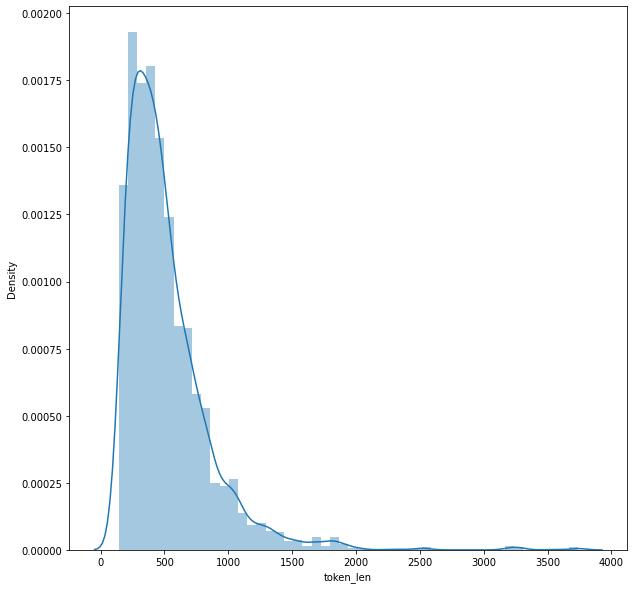

In [ ]:
x_tokens_len = [len(i) for i in X_tokens]
x_tokens_len_df = pd.DataFrame(x_tokens_len, columns=["token_len"])
plt.figure(figsize=(10,10))
sns.distplot(x_tokens_len_df["token_len"])
print("max length is: {}".format(max(x_tokens_len)))

# **News Categorization with LSTMs**

vocab_size 50740
timestep:  516
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 600, 100)          5074000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 598, 1024)         308224    
_________________________________________________________________
global_max_pooling1d (Global (None, 1024)              0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 500)               512500    
_________________________________________________________________
dense_27 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_9 (Dropout)  

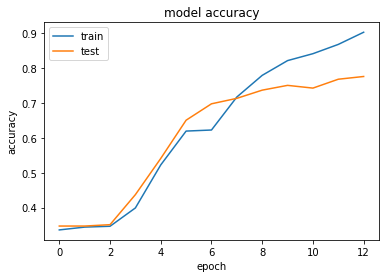

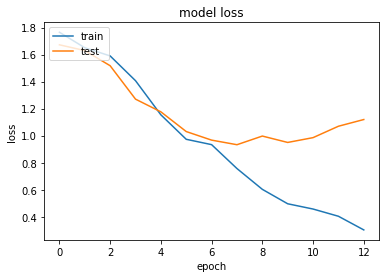

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import os
import shutil
import math

path = "/content/drive/My Drive/news_categorization/"

num_classes = 7
batch_size = 64
epochs = 20

if os.path.isdir(os.path.join(path, "news_categorization")):
    shutil.rmtree(os.path.join(path, "news_categorization"))

os.makedirs(os.path.join(path, "news_categorization"))
out_path = os.path.join(path, "news_categorization")

if not os.path.isdir("/content/drive/My Drive/news_categorization/lstm"):
    os.makedirs("/content/drive/My Drive/news_categorization/lstm")

merged_data = pd.read_csv("/content/drive/My Drive/news_categorization/merged_data.csv")
merged_data = shuffle(merged_data)
num_rows = merged_data.__len__()
X = merged_data["combined"]
Y = merged_data["category_id"].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42, stratify=Y)


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
# import keras_metrics
tokenizer_obj = Tokenizer()
total_text = np.concatenate([X_train , X_test])
tokenizer_obj.fit_on_texts(total_text)

#pad sequences
max_length = max([len(s.split()) for s in total_text])
max_length = 600

#define vocab size
vocab_size = len(tokenizer_obj.word_index)+1
print("vocab_size", vocab_size)

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)
x_train_token_len = [len(i) for i in X_train_tokens]
x_test_token_len = [len(i) for i in X_test_tokens]
x_tokens_len = x_train_token_len+x_test_token_len

import statistics
timestep = math.floor(statistics.mean(x_tokens_len))
print("timestep: ", timestep)

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='pre', truncating="post")
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='pre', truncating="post")

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
Embedding_dim = 100

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


#model train
early_stop_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(out_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.92, beta_2=0.99,amsgrad=False)

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, Embedding_dim, input_length=max_length))
lstm_model.add(CuDNNLSTM(units=512, input_shape=(timestep, max_length),return_sequences=False))
lstm_model.add(Flatten())
lstm_model.add(Dense(500, activation='relu'))
# model.add(Dropout(0.2))
lstm_model.add(Dense(300, activation='relu'))
lstm_model.add(Dropout(0.3))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.5))
lstm_model.add(Dense(7, activation='softmax'))
lstm_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy'])
print(model.summary())
lstm_model_history = lstm_model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_pad, y_test), callbacks=[early_stop_callback])
model.save(os.path.join("/content/drive/My Drive/news_categorization/lstm",'lstm_model.h5'))

import matplotlib.pyplot as plt
# summarize history for accracy
plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join("/content/drive/My Drive/news_categorization/lstm","accuracy.png"))
plt.close()

# summarize history for loss
plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join("/content/drive/My Drive/news_categorization/lstm","loss.png"))
plt.close()

# **News Categorization with Convolution Neural Network**

vocab_size 50740
timestep:  516
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 600, 100)          5074000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 598, 1024)         308224    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 1024)              0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 500)               512500    
_________________________________________________________________
dense_51 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_17 (Dropout) 

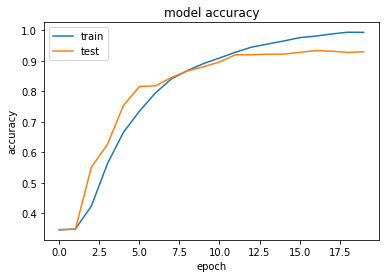

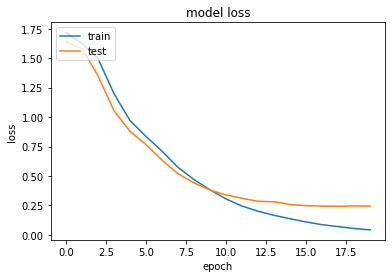

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import os
import shutil
import math

path = "/content/drive/My Drive/news_categorization/"

num_classes = 7
batch_size = 64
filters = 1024
kernel_size = 3
epochs = 20

if os.path.isdir(os.path.join(path, "news_categorization")):
    shutil.rmtree(os.path.join(path, "news_categorization"))

os.makedirs(os.path.join(path, "news_categorization"))
out_path = os.path.join(path, "news_categorization")

if not os.path.isdir("/content/drive/My Drive/news_categorization/cnn"):
    os.makedirs("/content/drive/My Drive/news_categorization/cnn")

merged_data = pd.read_csv("/content/drive/My Drive/news_categorization/merged_data.csv")
merged_data = shuffle(merged_data)
num_rows = merged_data.__len__()
X = merged_data["combined"]
Y = merged_data["category_id"].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42, stratify=Y)


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
# import keras_metrics
tokenizer_obj = Tokenizer()
total_text = np.concatenate([X_train , X_test])
tokenizer_obj.fit_on_texts(total_text)

#pad sequences
max_length = max([len(s.split()) for s in total_text])
max_length = 600

#define vocab size
vocab_size = len(tokenizer_obj.word_index)+1
print("vocab_size", vocab_size)

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)
x_train_token_len = [len(i) for i in X_train_tokens]
x_test_token_len = [len(i) for i in X_test_tokens]
x_tokens_len = x_train_token_len+x_test_token_len


X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='pre', truncating="post")
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='pre', truncating="post")

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical

Embedding_dim = 100

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


#model train
early_stop_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(out_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.92, beta_2=0.99,amsgrad=False)

cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, Embedding_dim, input_length=max_length))
cnn_model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(500, activation='relu'))
# model.add(Dropout(0.2))
cnn_model.add(Dense(300, activation='relu'))
cnn_model.add(Dropout(0.3))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.5))
cnn_model.add(Dense(7, activation='softmax'))
cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy'])
print(cnn_model.summary())
cnn_model_history = cnn_model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_pad, y_test), callbacks=[early_stop_callback])
model.save(os.path.join("/content/drive/My Drive/news_categorization/cnn",'cnn_model.h5'))

import matplotlib.pyplot as plt
# summarize history for accracy
plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join("/content/drive/My Drive/news_categorization/cnn","accuracy.png"))
plt.close()

# summarize history for loss
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join("/content/drive/My Drive/news_categorization/cnn","loss.png"))
plt.close()

# **News Categorization with Fine-tuning the BertForSequenceClassification**

**GPU setup**

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


**Installing transformers**

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.1MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 7.2MB/s 
     |████████████████████████████████| 890kB 17.4MB/s 
     |████████████████████████████████| 3.0MB 13.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d69f638930c0e8ccdd67da8cbbb38addc8aff9162f65b8b3ecf4f052d4d4aaa0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


**get BERT tokenizer**

In [ ]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


**Import Data**

In [ ]:
import pandas as pd
merged_data = pd.read_csv("/content/drive/My Drive/news_categorization/merged_data.csv")
merged_data.loc[merged_data["category_id"] == 0].sample(5)[['combined', 'category_id']]

,combined,category_id
988,"MARYSVILLE, Ohio (AP) \u2014 Honda is slowing ...",0
370,A car parts manufacturer is set to cut 95 staf...,0
3812,Morgan Stanley ($NYSE:MS) will close all banki...,0
4006,"PARIS (Reuters) - Carrefour plans to axe 3,000...",0
52,"ResCare Community Living, a BrightSpring Healt...",0


**fetch the required the data**

In [ ]:
sentences = merged_data["combined"].values
labels = merged_data["category_id"].values

**Visualizing the token_ids and tokens**

In [ ]:
print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  He said his plans would be discussed with the board of Foxconn, the world's largest contract manufacturer, formally known as Hon Hai Precision Industry Co Ltd.Foxconn chairman Gou says he aims to step down in coming monthsTAIPEI (Reuters) - The chairman of Taiwan's Foxconn, assembler of Apple Inc's iPhones, told Reuters on Monday he plans to step down in the coming months, saying he wants to pave the way for younger talent to move up the ranks of the company.\n\nTerry Gou, speaking on the sidelines of an event in Taipei, said that while he planned to step down as chairman, he hoped to remain involved in strategic decisions regarding the company's business.\n\nHe said his plans would be discussed with the board of Foxconn, the world's largest contract manufacturer, formally known as Hon Hai Precision Industry Co Ltd.\n\n(Reporting By Yimou Lee; Writing by Anne Marie Roantree; Editing by Muralikumar Anantharaman)
Tokenized:  ['he', 'said', 'his', 'plans', 'would', 'be', 'disc

In [ ]:
# max_len = 0

# for sent in sentences:
#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(sent, add_special_tokens=True)
#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

# print('Max sentence length: ', max_len)

**Visualize the length of various text sentences**

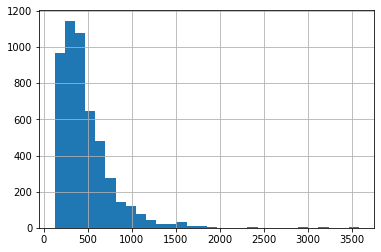

In [ ]:
seq_len = [len(i.split()) for i in sentences]
pd.Series(seq_len).hist(bins = 30)

**Tokenization**

In [ ]:
input_ids = []
attention_masks = []
import logging

# logging.getLogger("pytorch_pretrained_bert.tokenization").setLevel(logging.ERROR)

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 512,    
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                        truncation=True
                   )
   
    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  He said his plans would be discussed with the board of Foxconn, the world's largest contract manufacturer, formally known as Hon Hai Precision Industry Co Ltd.Foxconn chairman Gou says he aims to step down in coming monthsTAIPEI (Reuters) - The chairman of Taiwan's Foxconn, assembler of Apple Inc's iPhones, told Reuters on Monday he plans to step down in the coming months, saying he wants to pave the way for younger talent to move up the ranks of the company.\n\nTerry Gou, speaking on the sidelines of an event in Taipei, said that while he planned to step down as chairman, he hoped to remain involved in strategic decisions regarding the company's business.\n\nHe said his plans would be discussed with the board of Foxconn, the world's largest contract manufacturer, formally known as Hon Hai Precision Industry Co Ltd.\n\n(Reporting By Yimou Lee; Writing by Anne Marie Roantree; Editing by Muralikumar Anantharaman)
Token IDs: tensor([  101,  2002,  2056,  2010,  3488,  2052,  20

**Do train and validation Split**

In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,581 training samples
  510 validation samples


**Create train_dataloader and validation_dataloader for model training and evaluation**

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )


validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

**get classification model, we gonna use BertForSequenceClassification class of BERT**

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 7,
                       
    output_attentions = False, 
    output_hidden_states = False
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

**Optimizer and Learning rate scheduler**

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )
from transformers import get_linear_schedule_with_warmup

epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

**Define function to calculate accuracy**

In [ ]:
import numpy as np

def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

**Define a function to format the time taken in traing steps**

In [ ]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_train_accuracy += accuracy(logits, label_ids)
        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()


    avg_train_loss = total_train_loss / len(train_dataloader) 
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)        

    training_time = format_time(time.time() - t0)

    print("")
    print("  Training Accuracy: {0:.2f}".format(avg_train_accuracy))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        

            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accuracy':avg_train_accuracy,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    573.    Elapsed: 0:00:19.
  Batch    80  of    573.    Elapsed: 0:00:37.
  Batch   120  of    573.    Elapsed: 0:00:55.
  Batch   160  of    573.    Elapsed: 0:01:13.
  Batch   200  of    573.    Elapsed: 0:01:31.
  Batch   240  of    573.    Elapsed: 0:01:50.
  Batch   280  of    573.    Elapsed: 0:02:08.
  Batch   320  of    573.    Elapsed: 0:02:26.
  Batch   360  of    573.    Elapsed: 0:02:44.
  Batch   400  of    573.    Elapsed: 0:03:02.
  Batch   440  of    573.    Elapsed: 0:03:20.
  Batch   480  of    573.    Elapsed: 0:03:38.
  Batch   520  of    573.    Elapsed: 0:03:56.
  Batch   560  of    573.    Elapsed: 0:04:15.

  Training Accuracy: 0.85
  Average training loss: 0.51
  Training epcoh took: 0:04:20

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.19
  Validation took: 0:00:09

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    573.    Elapsed: 0:00:18.
  Batch    80  of    573.    E

In [ ]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy,Training Time,Validation Time
epoch,,,,,,
1,0.51,0.85,0.19,0.96,0:04:20,0:00:09
2,0.13,0.97,0.17,0.96,0:04:19,0:00:09
3,0.06,0.99,0.14,0.97,0:04:19,0:00:09


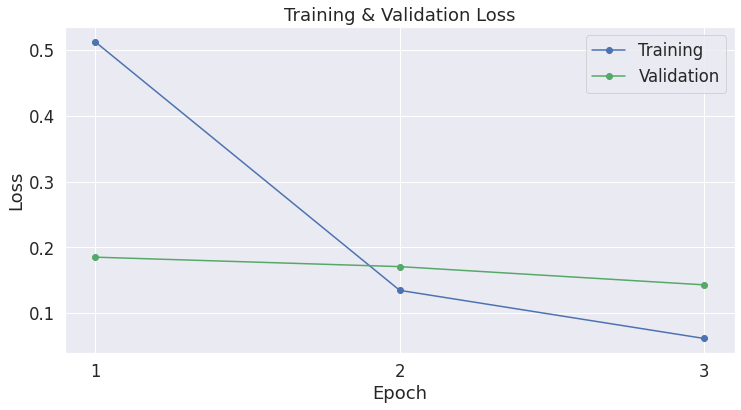

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

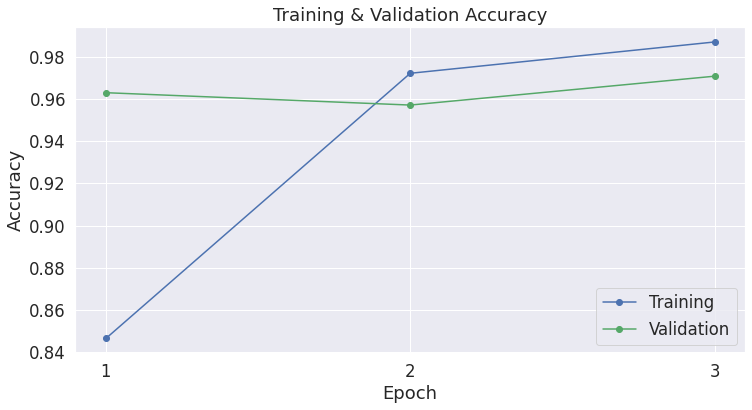

In [ ]:
plt.plot(df_stats['Training Accuracy'], 'b-o', label="Training")
plt.plot(df_stats['Validation Accuracy'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

**Save the fine-tuned model**

In [ ]:
import os
import json

output_dir = '/content/drive/My Drive/news_categorization/bert'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# **Conclusion**

From the above three model(lstm, cnn and BERT) we can directly see that 
BERT is the best performing model


Below performance results were found:

1. LSTM: 
         train_loss: 0.3022 
         train_ccuracy: 0.9035
         val_loss: 1.1194
         val_accuracy: 0.7765

    Here we can see that this is a certain case of overfitting, But I tried out various experiments with drop_out rate , number of neurons/layers but was not able to achieve more that 78% accuracy on validation data, while training with LSTMs

2. CNN: 
        train_loss: 0.0425
        train_accuracy: 0.9930
        val_loss: 0.2438
        val_accuracy: 0.9294
    with CNN we are able to get better and more robust results than training with LSTMs but validation loss is still more.

3. BERT: 
        train_loss: 0.06
        train_accuracy: 0.99
        validation_loss = 0.14
        validation_accuracy: 0.97
    Here we can see that fine-tuned BertForSequenceClassification model is the best performer among all other classifiers.This model is more robust as we are fine-tuning the pretrained BertForSequenceClassification model on our dataset. Hence results with  BertForSequenceClassification model are more robust and loss function values are now acceptable.


Clearly we can see that the fine-tuned BertForSequenceClassification model is the winner.
It the best model we can get using transfer learning.

# **Function to make inference from best model (BERT Fine-Tuned Model)**



Below steps are required before calling the get_predictions() function on text sentences.

In [ ]:
!pip install transformers
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer
import json
import torch
import pandas as pd
import numpy as np
import os
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


**Load the model and tokenizer**

In [ ]:
output_dir = '/content/drive/My Drive/news_categorization/bert'


config = BertConfig.from_pretrained(output_dir)
model = BertForSequenceClassification.from_pretrained(output_dir,
                                                      output_attentions = False, 
                                                      output_hidden_states = False)
model.to(device)

tokenizer = BertTokenizer.from_pretrained(output_dir) 


**Preprocess the text before passing to the model**

In [ ]:
data_path = "/content/drive/My Drive/news_categorization/data"

categories_data = pd.read_csv(os.path.join(data_path,"categories.csv"))
categories_mapping = pd.read_excel(os.path.join(os.path.join(data_path, "category_mapping.xlsx")))
news_details = pd.read_excel(os.path.join(data_path, "news_details.xlsx"))

categories_mapping["category_id"] = categories_mapping["category_id"].apply(lambda x:int(x)-1)
print("Before dropping nan: ")
print(news_details.isna().sum())
news_details.dropna(inplace=True)
print("\nAfter dropping nan: ")
print(news_details.isna().sum())

merged_data = pd.merge(categories_mapping, news_details, on=["news_id"], how="inner")
merged_data["combined"] = merged_data["snippet"]+merged_data["title"]+merged_data["news_description"]

Before dropping nan: 
news_id               0
snippet               7
title                 0
news_description    190
dtype: int64

After dropping nan: 
news_id             0
snippet             0
title               0
news_description    0
dtype: int64


In [ ]:
category_dict = categories_data.to_dict()
category_dict

{'category': {0: 'Layoff',
  1: 'Mergers and Acquisitions',
  2: 'Mass Hiring',
  3: 'Executive Movement',
  4: 'Centre Setup and Expansion',
  5: 'Deals',
  6: 'Partnerships'},
 'id': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}}

In [ ]:
def get_tokens_and_mask(text):
    
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = 512, 
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',    
                        truncation=True
                )
    return encoded_dict

**Defining the get_predictions function which takes one text senetence as an argument and return its respective category**

and for the demo purpose , 20 datapoints got sampled out randomly from the dataset and made category Prediction on them

In [ ]:
def get_predictions(text):
    model.eval()
    with torch.no_grad():
        inputs = get_tokens_and_mask(text)
        
        with torch.no_grad(): 
            preds = model(**inputs)
            pred_idx = np.argmax(preds[0].numpy().ravel())
    
    return category_dict["category"][pred_idx]

#demo get prediction

sample_data = merged_data.sample(20)
texts = sample_data["combined"].values
news_desctiption = sample_data["news_description"].values
categories = sample_data["category_id"].values
pred_data_frame = pd.DataFrame(columns=["actual category", "predicted category"])

for text, news, category in zip(texts,news_desctiption, categories):
    predicted_category = get_predictions(text)
    actual_category = category_dict["category"][category]
    d = {"actual category":actual_category , "predicted category":predicted_category}
    pred_data_frame = pred_data_frame.append(d, ignore_index=True)

    print("\033[96m newz:: ", news)
    print("\033[92m Actual Category:: ", actual_category) 
    print("\033[94m Predicted Category:: ", predicted_category)
    print("")


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


 newz::  NEW DELHI: The Competition Commission Thursday said it has given approval to Schneider's acquisition of Larsen & Toubro's electrical and automation business in a ?14,000-crore deal.\n\nHowever, the deal is subject to compliance of certain modifications, the Competition Commission of India (CCI) said.\n\nThe green signal comes after the regulator had sought comments from the public in November last year on the proposed acquisition by Schneider after finding that it could have an adverse impact on competition.\n\nIn a tweet, the CCI said it "approves acquisition of electrical and automation business of L&T by Schneider and MacRitchie, subject to compliance of certain modifications".\n\nIn May 2018, Larsen & Toubro had inked a definitive pact with Schneider Electric to sell its electrical and automation business for an all-cash consideration of ?14,000 crore, as part of its long-term strategy to exit non-core activities.\n\nAccording to notice submitted to the CCI, the proposed d

In [ ]:
pred_data_frame

,actual category,predicted category
0,Deals,Deals
1,Executive Movement,Executive Movement
2,Executive Movement,Executive Movement
3,Centre Setup and Expansion,Centre Setup and Expansion
4,Deals,Deals
5,Partnerships,Partnerships
6,Executive Movement,Executive Movement
7,Executive Movement,Executive Movement
8,Mergers and Acquisitions,Mergers and Acquisitions
9,Partnerships,Partnerships


We can see from the above results , that model is performing good.

You can try out get_prediction() function on your own test data set.